# Bond Option Pricing Tree Convergence with Volatility

Value an option on a coupon paying bond using the Hull-White, Black-Derman-Toy and Black-Karasinski model

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from financepy.utils import *
from financepy.market.curves import *
from financepy.models.bk_tree import BKTree
from financepy.models.bdt_tree import BDTTree
from financepy.models.hw_tree import HWTree
from financepy.products.bonds import *

## Set up the Discount Curve

In [3]:
settle_dt = Date(1, 9, 2019)

Set up discount curve

In [4]:
rate = 0.05
fixed_freq = FrequencyTypes.ANNUAL
discount_curve = DiscountCurveFlat(settle_dt, rate, fixed_freq)

## Setting up the Bond

In [5]:
issue_dt = Date(1, 9, 2014)
maturity_dt = Date(1, 9, 2025)
coupon = 0.06
freq_type = FrequencyTypes.ANNUAL
dc_type = DayCountTypes.ACT_ACT_ICMA
bond = Bond(issue_dt, maturity_dt, coupon, freq_type, dc_type)

face = 100.0

In [6]:
bond.cpn_dts

[01-SEP-2014,
 01-SEP-2015,
 01-SEP-2016,
 01-SEP-2017,
 01-SEP-2018,
 01-SEP-2019,
 01-SEP-2020,
 01-SEP-2021,
 01-SEP-2022,
 01-SEP-2023,
 01-SEP-2024,
 01-SEP-2025]

In [7]:
bond.flow_amounts

[0.0, 0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 0.06]

## Setting up the Option

In [8]:
expiry_dt = Date(1, 12, 2021)

Calculate the intrinsic

In [9]:
K = 102

In [10]:
df = discount_curve.df(expiry_dt)

Spot price and intrinsic

In [11]:
sp = bond.clean_price_from_discount_curve(settle_dt, discount_curve)
fp = bond.clean_price_from_discount_curve(expiry_dt, discount_curve)

In [12]:
print("Spot Bond Price: %9.5f" % sp)
print("Forward Bond Price: %9.5f" % fp)

Spot Bond Price: 105.07523
Forward Bond Price: 103.31706


In [13]:
call_intrinsic = max(sp - K, 0)
put_intrinsic = max(K - sp, 0)

In [14]:
print("Call Intrinsic Spot: %9.5f" % call_intrinsic)
print("Put  Intrinsic Spot: %9.5f" % put_intrinsic)

Call Intrinsic Spot:   3.07523
Put  Intrinsic Spot:   0.00000


Forward bond price and PV of intrinsic

In [15]:
call_intrinsic_pv = max(fp - K, 0) * df
put_intrinsic_pv = max(K - fp, 0) * df

In [16]:
print("Call Intrinsic Fwd: %9.5f" % call_intrinsic_pv)
print("Put  Intrinsic Fwd: %9.5f" % put_intrinsic_pv)

Call Intrinsic Fwd:   1.18017
Put  Intrinsic Fwd:   0.00000


## Convergence Testing

It is important that the tree price is stable to the number of tree steps. This can be a challenge when pricing American optionality on bonds due to the payment of coupons and the effect of accrued interest on the clean bond price.

We set the range of num steps.

In [17]:
num_stepsVector = range(500, 1000, 1)

In [18]:
blackVol = 0.20

## Hull White Model

It is important that the tree price is stable to the number of tree steps. This can be a challenge when pricing American optionality on bonds due to the payment of coupons and the effect of accrued interest on the clean bond price.

In [19]:
sigma = blackVol * rate
a = 0.1

vec_ec = []
vec_ac = []
vec_ep = []
vec_ap = []

for num_steps in num_stepsVector:

    hwModel = HWTree(sigma, a, num_steps)

    europeanCallBondOption = BondOption(bond, expiry_dt, K, OptionTypes.EUROPEAN_CALL)
    v_ec = europeanCallBondOption.value(settle_dt, discount_curve, hwModel)

    americanCallBondOption = BondOption(bond, expiry_dt, K, OptionTypes.AMERICAN_CALL)
    v_ac = americanCallBondOption.value(settle_dt, discount_curve, hwModel)

    europeanPutBondOption = BondOption(bond, expiry_dt, K, OptionTypes.EUROPEAN_PUT)
    v_ep = europeanPutBondOption.value(settle_dt, discount_curve, hwModel)

    americanPutBondOption = BondOption(bond, expiry_dt, K, OptionTypes.AMERICAN_PUT)
    v_ap = americanPutBondOption.value(settle_dt, discount_curve, hwModel)

    vec_ec.append(v_ec)
    vec_ac.append(v_ac)
    vec_ep.append(v_ep)
    vec_ap.append(v_ap)

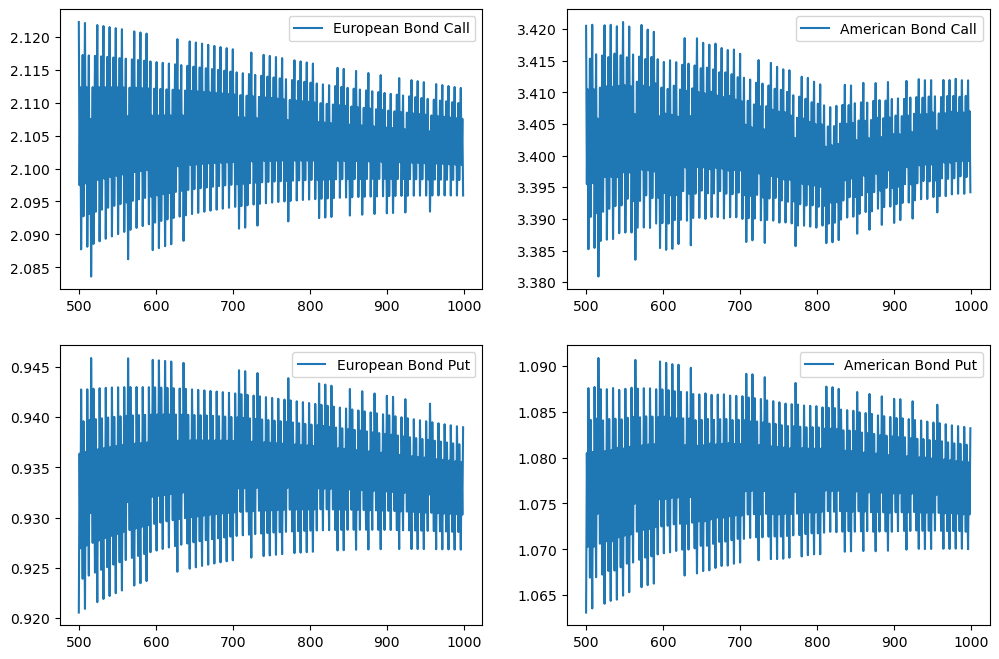

In [20]:
fig = plt.figure(figsize=(12,8))

plt.subplot(2,2,1)
plt.plot(num_stepsVector,vec_ec, label="European Bond Call")
plt.legend()

plt.subplot(2,2,2)
plt.plot(num_stepsVector,vec_ac, label="American Bond Call")
plt.legend();

plt.subplot(2,2,3)
plt.plot(num_stepsVector,vec_ep, label="European Bond Put")
plt.legend();

plt.subplot(2,2,4)
plt.plot(num_stepsVector,vec_ap, label="American Bond Put")
plt.legend();

Convergence is good. Averaging even and odd should help smooth.

## Black-Karasinski Model

In [21]:
sigma = blackVol
a = 0.1

vec_ec = []
vec_ac = []
vec_ep = []
vec_ap = []

for num_steps in num_stepsVector:

    bkModel = BKTree(sigma, a, num_steps)

    europeanCallBondOption = BondOption(bond, expiry_dt, K, OptionTypes.EUROPEAN_CALL)
    v_ec = europeanCallBondOption.value(settle_dt, discount_curve, bkModel)

    americanCallBondOption = BondOption(bond, expiry_dt, K, OptionTypes.AMERICAN_CALL)
    v_ac = americanCallBondOption.value(settle_dt, discount_curve, bkModel)

    europeanPutBondOption = BondOption(bond, expiry_dt, K, OptionTypes.EUROPEAN_PUT)
    v_ep = europeanPutBondOption.value(settle_dt, discount_curve, bkModel)

    americanPutBondOption = BondOption(bond, expiry_dt, K, OptionTypes.AMERICAN_PUT)
    v_ap = americanPutBondOption.value(settle_dt, discount_curve, bkModel)

    vec_ec.append(v_ec)
    vec_ac.append(v_ac)
    vec_ep.append(v_ep)
    vec_ap.append(v_ap)

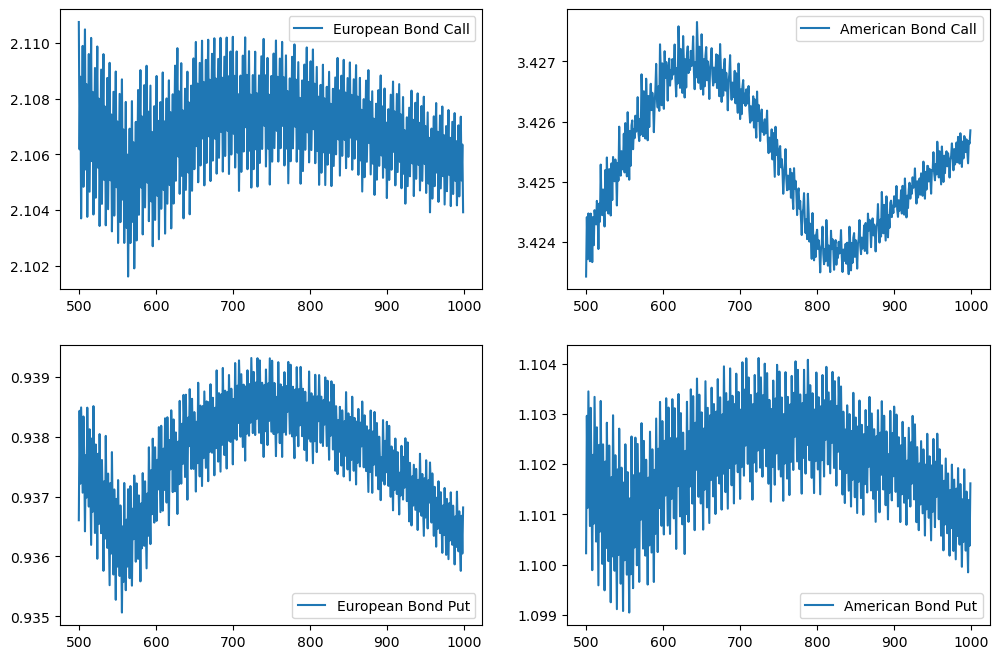

In [22]:
fig = plt.figure(figsize=(12,8))

plt.subplot(2,2,1)
plt.plot(num_stepsVector,vec_ec, label="European Bond Call")
plt.legend()

plt.subplot(2,2,2)
plt.plot(num_stepsVector,vec_ac, label="American Bond Call")
plt.legend();

plt.subplot(2,2,3)
plt.plot(num_stepsVector,vec_ep, label="European Bond Put")
plt.legend();

plt.subplot(2,2,4)
plt.plot(num_stepsVector,vec_ap, label="American Bond Put")
plt.legend();

## Black-Derman-Toy Model


In [23]:
sigma = blackVol

vec_ec = []
vec_ac = []
vec_ep = []
vec_ap = []

for num_steps in num_stepsVector:

    bdtModel = BDTTree(sigma, num_steps)

    europeanCallBondOption = BondOption(bond, expiry_dt, K, OptionTypes.EUROPEAN_CALL)
    v_ec = europeanCallBondOption.value(settle_dt, discount_curve, bdtModel)

    americanCallBondOption = BondOption(bond, expiry_dt, K, OptionTypes.AMERICAN_CALL)
    v_ac = americanCallBondOption.value(settle_dt, discount_curve, bdtModel)

    europeanPutBondOption = BondOption(bond, expiry_dt, K, OptionTypes.EUROPEAN_PUT)
    v_ep = europeanPutBondOption.value(settle_dt, discount_curve, bdtModel)

    americanPutBondOption = BondOption(bond, expiry_dt, K, OptionTypes.AMERICAN_PUT)
    v_ap = americanPutBondOption.value(settle_dt, discount_curve, bdtModel)

    vec_ec.append(v_ec)
    vec_ac.append(v_ac)
    vec_ep.append(v_ep)
    vec_ap.append(v_ap)

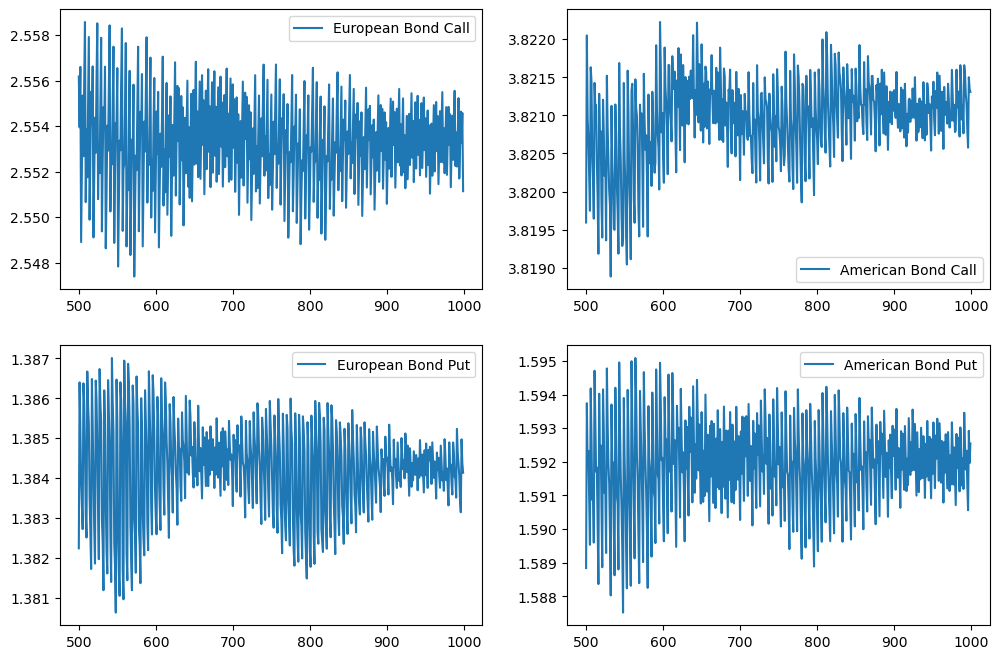

In [24]:
fig = plt.figure(figsize=(12,8))

plt.subplot(2,2,1)
plt.plot(num_stepsVector,vec_ec, label="European Bond Call")
plt.legend()

plt.subplot(2,2,2)
plt.plot(num_stepsVector,vec_ac, label="American Bond Call")
plt.legend();

plt.subplot(2,2,3)
plt.plot(num_stepsVector,vec_ep, label="European Bond Put")
plt.legend();

plt.subplot(2,2,4)
plt.plot(num_stepsVector,vec_ap, label="American Bond Put")
plt.legend();

Copyright (c) Dominic O'Kane 2020